# Tajima and Dawson

This notebook enables one to reproduce the simulations of T. Tajima and J. M. Dawson, "Laser Electron Accelerator." Phys. Rev. Lett. **43**, 267 (1979).

These are 1D simulations with a relativistic electromagnetic PIC code.

* $L_x = 512\Delta$
* $c = 5 v_e$
* $k_x = 2\pi / 15\Delta$
* number of electrons = 5120
* particle size = $1\Delta$

where:
* $\Delta$ is the unit spatial grid distance
* $v_e$ is the electron thermal speed

The following relations are kept fixed:
* $eE_0/m\omega = eB_0/m\omega = c$
* $L_t = \pi c/\omega_p$
* $p_0 = eE_0/\omega$
* $\omega = (\omega_p^2 + k_x^2c^2)^{1/2}$

where:
* $E_0$ and $B_0$ are the pump wave electric and magnetic field amplitudes
* $p_0$ is the corresponding amplitude for the momentum modulation


Cases are run for $c = [5, 7.25, 10, 14.7]\omega_p\Delta$.
* $E_y = E_0\sin k_x(x-x_0)$
* $B_z = B_0\sin k_x(x-x_0)$
* $p_y = p^{random}+p_0\cos k_x(x-x_0)$

"In this series of simulations, a run with larger $c$ means larger $\omega$, longer photon train $L_t$, and stronger $E_0$, since $\omega_p$ is taken to be constant."

In [1]:
# We first import necessary libraries

import sys
b= sys.path

sys.path=['/home/jovyan/analysis'] + b
import osiris
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from osh5vis import new_fig, osplot
from osh5io import read_h5
from osh5utils import fft
import glob
from ipywidgets import interact_manual,fixed,Layout
import ipywidgets as widgets
interact_calc=interact_manual.options(manual_name="Make New Input and Run")

import os
print(os.getcwd())

/home/jovyan/dev/Tajima-Dawson-1979


We will set a few variables:

* By definition in the article, $c = a\omega_p\Delta$ with $a=[5, 7.25, 10, 14.7]$
* Normalizations for OSIRIS will be set with $\omega_{p} = 1$ and $c = 1$, so we must recalculate some values.
* $v_e = 0.2c = 0.2a\omega_p\Delta$
* If $c$ is going to be temporarily variable, set $\Delta$ to be something specific -> $\Delta = 0.2$..... something seems fishy about these parameter transformations -> must check with others
* $L_x = 512\Delta = 102.4$
* 5120 particles gives 10 particles per cell

## Run the canonical case from the paper.

In [6]:
dirname = 'case0'
osiris.runosiris(rundir=dirname,inputfile='case0.txt')

TypeError: 'str' object is not callable

In [6]:
dx = 0.2

In [ ]:
# uncomment to get other ve
# c = [5, 7.25, 10, 14.7]
# for i in c:
#     ve = 0.2*i*dx
#     print('v_e = {:.2f}'.format(ve))


For laser frequency:

* $\omega = (\omega_p^2 + k_x^2c^2)^{1/2}$
* $\omega^2/\omega_p^2 = 1 + a^2k_x^2\Delta^2$
* Since $k_x\Delta = (2\pi/15)$, we have $\omega^2/\omega_p^2 = 1 + a^2(2\pi/15)^2$

In [2]:
c = [5, 7.25, 10, 14.7]
for i in c:
    w2 = 1 + (i**2)*(2*np.pi/15)**2
    w = np.sqrt(w2)
    print('w^2/wp^2 = {:.2f}, w/wp = {:.2f}'.format(w2, w))

w^2/wp^2 = 5.39, w/wp = 2.32
w^2/wp^2 = 10.22, w/wp = 3.20
w^2/wp^2 = 18.55, w/wp = 4.31
w^2/wp^2 = 38.92, w/wp = 6.24


For the laser antenna $a_0 = (E_0/\omega)$

Since $E_0$ is kept to be $E_0 = m\omega c /e$, then $a_0 = mc/e$

For $m = e = 1$, $a_0 = a\omega_p\Delta = a * 0.2$

In [ ]:
c = [5, 7.25, 10, 14.7]
for i in c:
    a0 = i*dx
    print('a0 = {:.2f}'.format(a0))

Finally, the laser train length is $L_t = \pi c/\omega_p$

$L_t = \pi/\omega_p (a\omega_p\Delta) = \pi a \Delta$

In [ ]:
c = [5, 7.25, 10, 14.7]
for i in c:
    Lt = i*np.pi*dx
    print('Lt = {:.2f}'.format(Lt))

In [7]:
# function definitions for later

def plot_maxgamma_t(simdir):
    maxg, time = [], []
    for f in sorted(glob.glob(simdir + '/MS/PHA/p1x1/electrons/*.h5')):
        data = read_h5(f)
        ind = np.nonzero(data)
        maxg.append(np.sqrt(1+(data.axes[0][max(ind[0])])**2))
        time.append(data.run_attrs['TIME'])
    print('max gamma = ', max(maxg))
    
def newifile(iname='case1.txt', oname='case2.txt', uth=0.1, a0=1.0, omega0=2.0, t_flat=3.14):

    with open(iname) as osdata:
        data = osdata.readlines()

    for i in range(len(data)):
        if 'uth(1:3)' in data[i]:
            data[i] = 'uth(1:3) = '+str(uth)+'d0 , '+str(uth)+'d0 , '+str(uth)+'d0,\n'
        if 'uth_bnd(1:3,1,1)' in data[i]:
            data[i] = 'uth_bnd(1:3,1,1) = '+str(uth)+'d0 , '+str(uth)+'d0 , '+str(uth)+'d0,\n'
        if 'uth_bnd(1:3,2,1)' in data[i]:
            data[i] = 'uth_bnd(1:3,2,1) = '+str(uth)+'d0 , '+str(uth)+'d0 , '+str(uth)+'d0,\n'
        if 'a0 =' in data[i] and 'omega0' not in data[i]:
            data[i] = 'a0 = '+str(a0)+',\n'
        if 'omega0 =' in data[i]:
            data[i] = 'omega0 = '+str(omega0)+',\n'
        if 't_flat =' in data[i]:
            data[i] = 't_flat = '+str(t_flat)+',\n'

    with open(oname,'w') as f:
        for line in data:
            f.write(line)
    
    print('New file '+oname+' is written.')
    dirname = oname.strip('.txt')
    print('Running OSIRIS in directory '+dirname+'...')
    osiris.runosiris(rundir=dirname,inputfile=oname,print='no')
    plot_maxgamma_t(dirname)
    print('Done')

### our set of parameters to test for Figure 2

In [9]:
c = [5, 7.25, 10, 14.7]
for i in c:
#     ve = 0.2*i*dx
    ve = 0.2
    a0 = i*dx
    w = np.sqrt(1 + (i**2)*(2*np.pi/15)**2)
    Lt = i*np.pi*dx
    print('For c = {:5.2f}, v_e = {:4.2f}, a0 = {:4.2f}, w/wp = {:4.2f}, Lt = {:4.2f}'.format(i,ve,a0,w,Lt))

For c =  5.00, v_e = 0.20, a0 = 1.00, w/wp = 2.32, Lt = 3.14
For c =  7.25, v_e = 0.20, a0 = 1.45, w/wp = 3.20, Lt = 4.56
For c = 10.00, v_e = 0.20, a0 = 2.00, w/wp = 4.31, Lt = 6.28
For c = 14.70, v_e = 0.20, a0 = 2.94, w/wp = 6.24, Lt = 9.24


In [8]:
style = {'description_width': '150px'}
layout = Layout(width='35%')

a = widgets.Text(value='case0.txt', description='Template Input File',style=style,layout=layout)
b = widgets.Text(value='case1.txt', description='New Output File',style=style,layout=layout)
c = widgets.FloatText(value=0.2, min=0.0, max=2.0, description='v_e/c:',style=style,layout=layout)
d = widgets.FloatText(value=1.0,description='a0:',style=style,layout=layout)
e = widgets.FloatText(value=2.0,description='omega0:',style=style,layout=layout)
f = widgets.FloatText(value=3.14, min=0, max=100, description='Lt:',style=style,layout=layout)

interact_calc(newifile,iname=a,oname=b,uth=c,a0=d,omega0=e,t_flat=f);

interactive(children=(Text(value='case0.txt', description='Template Input File', layout=Layout(width='35%'), s…

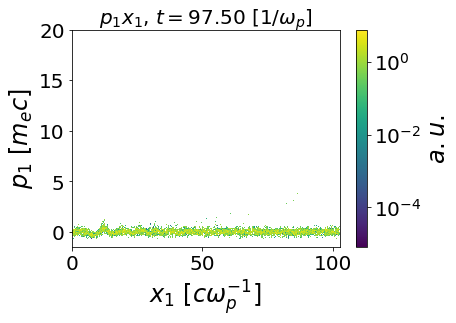

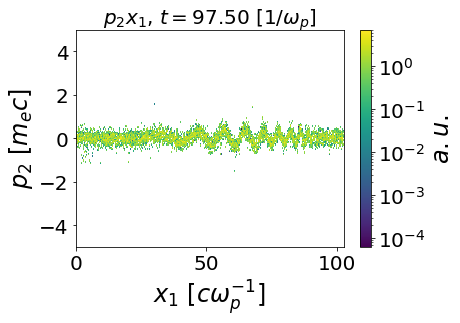

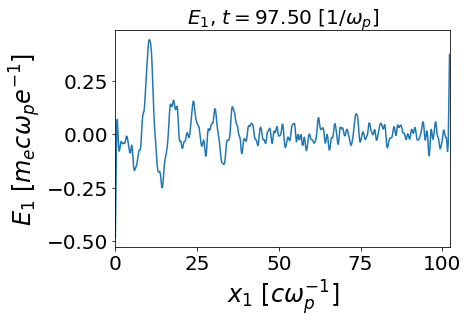

In [21]:
dirname = './case1'
p1x1=read_h5(dirname + '/MS/PHA/p1x1/electrons/p1x1-electrons-000500.h5')
new_fig(np.abs(p1x1), norm=LogNorm(), xlim=[0, 102.4], ylim=[-1.5, 20])
p2x1=read_h5(dirname + '/MS/PHA/p2x1/electrons/p2x1-electrons-000500.h5')
new_fig(np.abs(p2x1), norm=LogNorm(), xlim=[0, 102.4], ylim=[-5, 5])
e1 = read_h5(dirname + '/MS/FLD/e1/e1-000500.h5')
new_fig(e1, xlim=[0, 102.4])

In [2]:
from osiris import tajima
dirname = './case1'
tajima(rundir=dirname)

p1x1-electrons-000005.h5
00005


interactive(children=(IntSlider(value=0, description='file_no', max=1260, step=5), Output()), _dom_classes=('w…

In [11]:
dirname = './case2'
plt.figure()
osplot(np.abs(fft(read_h5(dirname+'/MS/FLD/e2/e2-000030.h5'))), xlim=[0, 6], ylim=[0, 70])
osplot(np.abs(fft(read_h5(dirname+'/MS/FLD/e2/e2-000205.h5'))), xlim=[0, 6], ylim=[0, 70])
osplot(np.abs(fft(read_h5(dirname+'/MS/FLD/e2/e2-000410.h5'))), xlim=[0, 6], ylim=[0, 70])
plt.title('$E_2$')
plt.legend(['t=5.9', 't=40', 't=80'])

OSError: Unable to open file (unable to open file: name = './case2/MS/FLD/e2/e2-000030.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

<Figure size 432x288 with 0 Axes>